surfplot only works in earlier version of matplotlib, thus we need to downgrade the matplotlib to `3.4.3`

In [1]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
from enigmatoolbox.utils.parcellation import parcel_to_surface

import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from nilearn import plotting, datasets, surface
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from statsmodels.stats.multitest import multipletests as fdr
%matplotlib inline

more examples https://surfplot.readthedocs.io/en/latest/

In [2]:
#print(matplotlib.__version__)
#!pip uninstall matplotlib
#!pip install matplotlib==3.4.3

3.4.3


## Prepare the data for plotting
### Load them

In [2]:
# set dirs
base_dir = '/Volumes/GoogleDrive/My Drive/Gradient_Shift_Cellular_Basis/Milgram'
gradient_dir = base_dir+'/data/Gradients_Margulies2016'
figure_dir = base_dir+'/figures/surface_plots'

# the 7 networks
schaefer400_7Networks = pd.read_csv(gradient_dir+'/schaefer_400_7Net_labels_manually_added.csv',header=None,index_col=0)

# Gradient
gradient1_hcp_schaefer400 = pd.read_csv(gradient_dir+'/gradient_1_schaefer_400_fsa5.csv',header=None)
gradient2_hcp_schaefer400 = pd.read_csv(gradient_dir+'/gradient_2_schaefer_400_fsa5.csv',header=None)
# insert first column as 0 for label 0
gradient1_hcp_schaefer400.insert(0,'0',[0])
gradient2_hcp_schaefer400.insert(0,'0',[0])

# Cell Types
LakeDFC_schaefer400 = pd.read_csv(gradient_dir+'/schaeffer_LAKE_DFC_400_7Net_expr_mat_new_NormZscore0.3.csv',header=None,index_col=0)
LakeDFC_schaefer400.replace(0,0.0001,inplace=True)
LakeVIS_schaefer400 = pd.read_csv(gradient_dir+'/schaeffer_LAKE_VIS_400_7Net_expr_mat_new_NormZscore0.3.csv',header=0,index_col=0)
LakeVIS_schaefer400.replace(0,0.0001,inplace=True)
# insert first column as 0 for label 0
LakeDFC_schaefer400.insert(0,'0',np.zeros(len(LakeDFC_schaefer400)).tolist())
LakeVIS_schaefer400.insert(0,'0',np.zeros(len(LakeVIS_schaefer400)).tolist())

### Map parcel to vertex

In [3]:
# Gradients
gradient1_hcp_fsaverage6 = parcel_to_surface(gradient1_hcp_schaefer400.loc[0].to_numpy(), 'schaefer_400_fsa6')
gradient2_hcp_fsaverage6 = parcel_to_surface(gradient2_hcp_schaefer400.loc[0].to_numpy(), 'schaefer_400_fsa6')
schaefer400_7Networks_fsaverage6 = parcel_to_surface(schaefer400_7Networks[1].to_numpy(), 'schaefer_400_fsa6')

# for cell types
cell_types_DFC = list(LakeDFC_schaefer400.index.values)
cell_types_VIS = list(LakeVIS_schaefer400.index.values)
LakeDFC_fsa6 = {}
LakeVIS_fsa6 = {}
for this_cell in list(range(len(cell_types_DFC))):
    LakeDFC_fsa6[cell_types_DFC[this_cell]] = parcel_to_surface(LakeDFC_schaefer400.loc[cell_types_DFC[this_cell]].to_numpy(), 'schaefer_400_fsa6')
    LakeVIS_fsa6[cell_types_VIS[this_cell]] = parcel_to_surface(LakeVIS_schaefer400.loc[cell_types_VIS[this_cell]].to_numpy(), 'schaefer_400_fsa6')

### Make plots

In [4]:
# download surfaces:
surfaces = fetch_fslr()
#surfaces = fetch_fslr(density='164k')
# check the available surfaces:
#surfaces.keys()
#---- output ----
# dict_keys(['midthickness', 'inflated', 'veryinflated', 'sphere', 'medial', 'sulc', 'vaavg'])
#---- output ----

# load schaefer parcellation labels (in fsaverage6)
lh_schaefer400, rh_schaefer400 = load_parcellation('schaefer')
# each vertex stores the corresponding parcel label
#lh_parc.shape
#---- output ----
# (32492,)
#---- output ----

# for gradients, vary inflated version can best visualize the details
lh, rh = surfaces['veryinflated']

vertex_per_hemi = int(len(schaefer400_7Networks_fsaverage6)/2)

In [5]:
lh_schaefer400

array([196,  67,  47, ..., 133, 133, 133])

In [6]:
lh_schaefer400.shape

(32492,)

#### 1. 7 networks

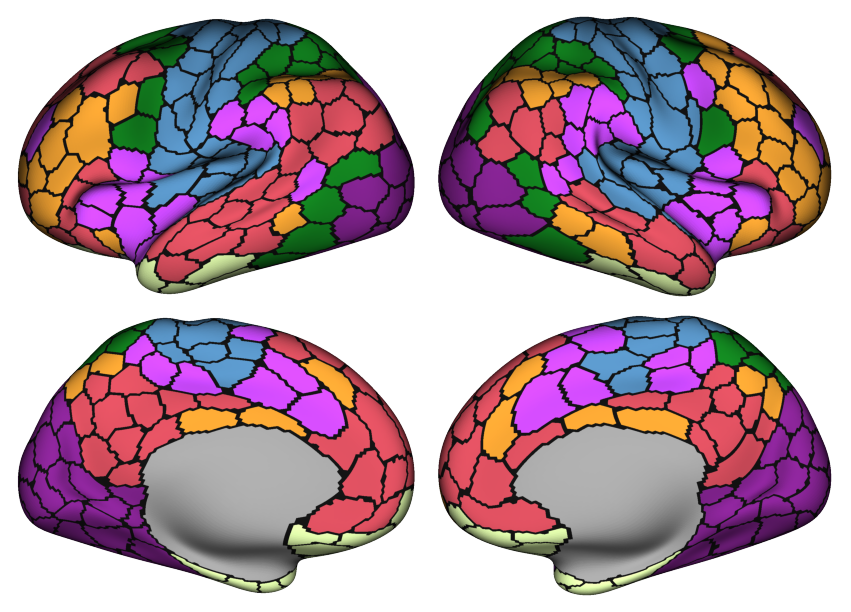

In [9]:
# color code for the 7 networks
yeo_cmap_RGB = [(120/255, 18/255, 134/255),
                (70/255, 130/255, 180/255),
                (0/255, 118/255, 14/255),
                (196/255, 58/255, 250/255),
                (220/255, 248/255, 164/255),
                (230/255, 148/255, 34/255),
                (205/255, 62/255, 78/255)]
colors = sns.color_palette(yeo_cmap_RGB, 7) 
yeo_cmap = LinearSegmentedColormap.from_list('yeo_cmap', colors, N=7)


# set up the surface plot base
p_7networks = Plot(lh, rh,size=(1400, 1000), zoom=1.7)

# make layer for the 7 networks
lh_7net = schaefer400_7Networks_fsaverage6[0:vertex_per_hemi]
rh_7net = schaefer400_7Networks_fsaverage6[vertex_per_hemi:]
p_7networks.add_layer({'left': lh_7net, 'right': rh_7net}, cmap=yeo_cmap, cbar=False) #cbar_label='Default mode'

# add layer for the schaefer 400 pacels outline
p_7networks.add_layer({'left': lh_schaefer400, 'right': rh_schaefer400}, cmap='gray', as_outline=True, cbar=False)

fig = p_7networks.build()
plt.savefig(figure_dir+'/Schaefer400_7Net_Surplot.pdf')

In [22]:
lh_7net

array([7, 2, 2, ..., 6, 6, 6])

In [24]:
lh_7net.shape

(32492,)

#### 2. Gradient1

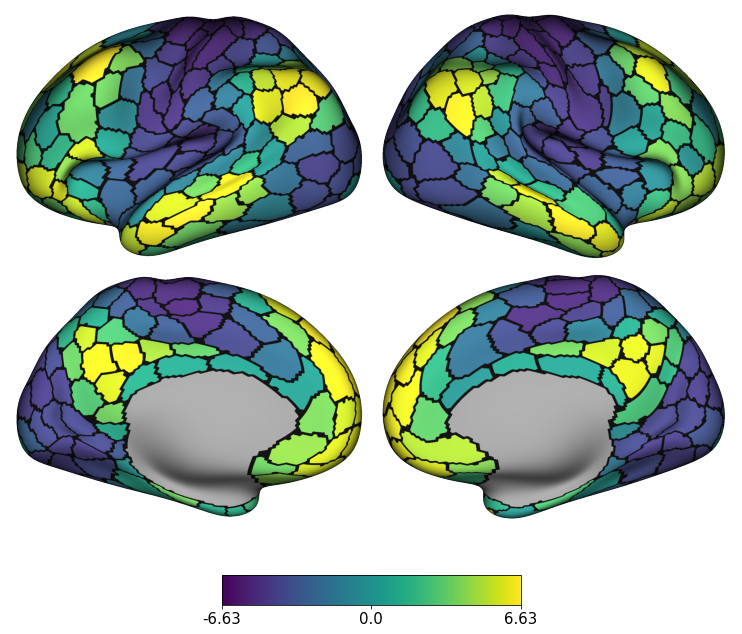

In [19]:
# set up the surface plot base
p_gradient1 = Plot(lh, rh,size=(1400, 1000), zoom=1.7)

# make layer for the 7 networks
lh_gradient1 = gradient1_hcp_fsaverage6[0:vertex_per_hemi]
rh_gradient1 = gradient1_hcp_fsaverage6[vertex_per_hemi:]
p_gradient1.add_layer({'left': lh_gradient1, 'right': rh_gradient1},color_range=(-np.max(gradient1_hcp_fsaverage6),np.max(gradient1_hcp_fsaverage6))) #cbar_label='Default mode'

# add layer for the schaefer 400 pacels outline
p_gradient1.add_layer({'left': lh_schaefer400, 'right': rh_schaefer400}, cmap='gray', as_outline=True, cbar=False)

kws = {'decimals': 2, 'shrink': .5,
       'fontsize': 15, 'n_ticks': 3, 'aspect': 10,
       'draw_border': True} #'label_direction': 45,'shrink': .15,

fig = p_gradient1.build(cbar_kws=kws)
plt.savefig(figure_dir+'/Gradient1_HCP_Schaefer400.pdf')

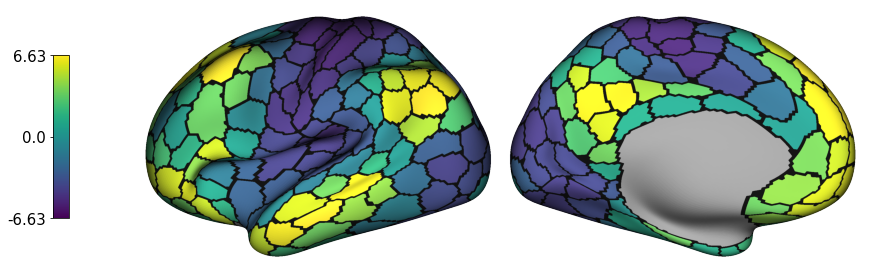

In [21]:
# set up the surface plot base
p_gradient1_L = Plot(lh,size=(1400, 500), zoom=1.7)

p_gradient1_L.add_layer(lh_gradient1,color_range=(-np.max(lh_gradient1),np.max(lh_gradient1))) #cbar_label='Default mode'

# add layer for the schaefer 400 pacels outline
p_gradient1_L.add_layer(lh_schaefer400, cmap='gray', as_outline=True, cbar=False)

# set label properties
kws = {'location': 'left',  'decimals': 2, 'shrink': .5,
       'fontsize': 15, 'n_ticks': 3, 'aspect': 10,
       'draw_border': True} #'label_direction': 45,'shrink': .15,

fig = p_gradient1_L.build(cbar_kws=kws)
plt.savefig(figure_dir+'/Gradient1_HCP_Schaefer400_L.pdf')

#### 3. Gradient 2

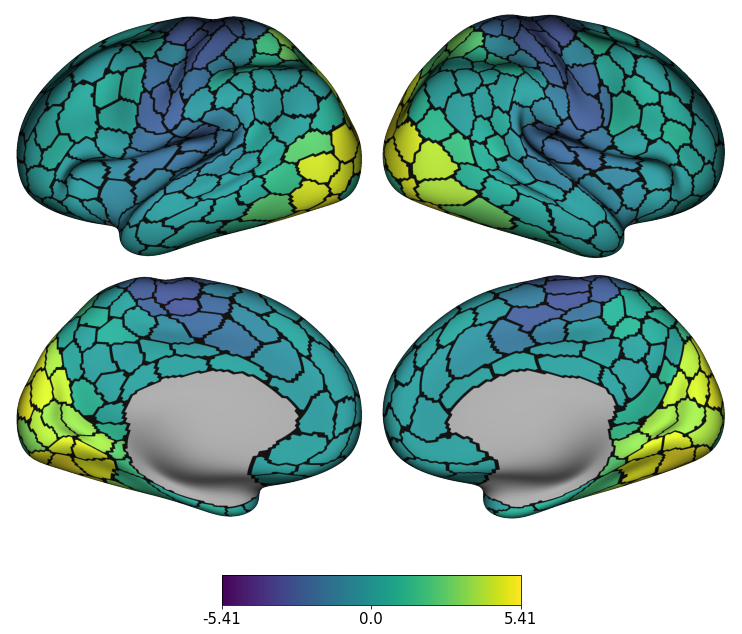

In [23]:
# set up the surface plot base
p_gradient2 = Plot(lh, rh,size=(1400, 1000), zoom=1.7)

# make layer for the 7 networks
lh_gradient2 = gradient2_hcp_fsaverage6[0:vertex_per_hemi]
rh_gradient2 = gradient2_hcp_fsaverage6[vertex_per_hemi:]
p_gradient2.add_layer({'left': lh_gradient2, 'right': rh_gradient2},color_range=(-np.max(gradient2_hcp_fsaverage6),np.max(gradient2_hcp_fsaverage6))) #cbar_label='Default mode'

# add layer for the schaefer 400 pacels outline
p_gradient2.add_layer({'left': lh_schaefer400, 'right': rh_schaefer400}, cmap='gray', as_outline=True, cbar=False)

kws = {'decimals': 2, 'shrink': .5,
       'fontsize': 15, 'n_ticks': 3, 'aspect': 10,
       'draw_border': True} #'label_direction': 45,'shrink': .15,

fig = p_gradient2.build(cbar_kws=kws)
plt.savefig(figure_dir+'/Gradient2_HCP_Schaefer400.pdf')

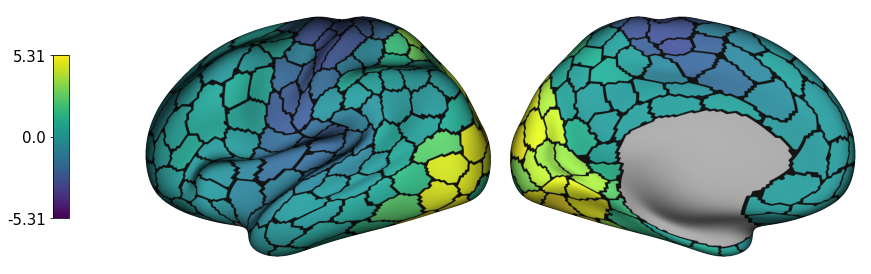

In [25]:
# set up the surface plot base
p_gradient2_L = Plot(lh,size=(1400, 500), zoom=1.7)

p_gradient2_L.add_layer(lh_gradient2,color_range=(-np.max(lh_gradient2),np.max(lh_gradient2))) #cbar_label='Default mode'

# add layer for the schaefer 400 pacels outline
p_gradient2_L.add_layer(lh_schaefer400, cmap='gray', as_outline=True, cbar=False)

# set label properties
kws = {'location': 'left',  'decimals': 2, 'shrink': .5,
       'fontsize': 15, 'n_ticks': 3, 'aspect': 10,
       'draw_border': True} #'label_direction': 45,'shrink': .15,

fig = p_gradient2_L.build(cbar_kws=kws)
plt.savefig(figure_dir+'/Gradient2_HCP_Schaefer400_L.pdf')